# Synopsis

Applying Syuzhet methods to *Persuasion* using NRC, Bing, Syuzhet, and VADER.

# Configuration

In [1]:
pwd = '/Users/rca2t/COURSES/DSI/DS5559/UVA_DSI_REPO/labs/2019-04-11_Lab11/'

# Developed in other notebook
lex_db = './lexicons.db'

# Developed in previous lab
# text_db = '../20/19-02-21_Lab06/persuasion.db'
text_db = '../2019-02-21_Lab06/moby.db'
OHCO = ['chap_num', 'para_num', 'sent_num', 'token_num']
CHAPS = OHCO[:1]
PARAS = OHCO[:2]
SENTS = OHCO[:3]

# emo = 'bing_sentiment'
emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

# Libraries

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import sys
import scipy.fftpack as fftpack
from sklearn.neighbors import KernelDensity as KDE
from sklearn.preprocessing import scale

import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

# Pragmas

In [3]:
%cd {pwd}
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

/Users/rca2t/Dropbox/Courses/DSI/DS5559/UVA_DSI_REPO/labs/2019-04-11_Lab11


# Process

## Get Lexicons

In [4]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [5]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.75,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.50,NaN
abandoner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-0.25,-1.0
abandons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,NaN


### Get lexicon columns

In [6]:
# emo_cols = [col for col in combo.columns if 'nrc_' in col]
emo_cols = combo.columns

In [7]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'syu_sentiment', 'gi_sentiment'],
      dtype='object')

## Get Text

In [8]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE punc = 0", db, index_col=OHCO)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

### Merge sentiment lexicon with vocab

In [9]:
tokens = tokens.join(combo, on='term_str', how='left')

In [10]:
tokens[emo].sample(10)

chap_num  para_num  sent_num  token_num
96        5         9         19          NaN
17        3         11        34          NaN
48        30        1         4           NaN
13        14        11        23          NaN
26        1         14        83          NaN
133       23        4         31          NaN
27        4         2         69          NaN
54        78        3         11          NaN
44        3         1         8           NaN
86        12        2         5           NaN
Name: syu_sentiment, dtype: float64

In [11]:
tokens[emo_cols] = tokens[emo_cols].fillna(0)

In [12]:
tokens.head(10)

pos    token_str  punc  num  \
chap_num para_num sent_num token_num                                
0        0        0        0          NNP    ETYMOLOGY     0    0   
         1        0        1          VBN     Supplied     0    0   
                           2           IN           by     0    0   
                           3           DT            a     0    0   
                           4           JJ         Late     0    0   
                           5          NNP  Consumptive     0    0   
                           6          NNP        Usher     0    0   
                           7           TO           to     0    0   
                           8           DT            a     0    0   
                           9          NNP      Grammar     0    0   

                                         term_str  term_id  nrc_anger  \
chap_num para_num sent_num token_num                                    
0        0        0        0            etymology     5005        0.0   
         1        0        1             supplied    14441        0.0   
                           2                   by     1987        0.0   
                           3                    a        0        0.0   
                           4                 late     8383        0.0   
                           5          consumptive     3099        0.0   
                           6                usher    15981        0.0   
                           7                   to    15076        0.0   
                           8                    a        0        0.0   
                           9              grammar     6389        0.0   

                                      nrc_anticipation  nrc_disgust  nrc_fear  \
chap_num para_num sent_num token_num                                            
0        0        0        0                       0.0          0.0       0.0   
         1        0        1                       0.0          0.0       0.0   
                           2                       0.0          0.0       0.0   
                           3                       0.0          0.0       0.0   
                           4                       0.0          0.0       0.0   
                           5                       0.0          0.0       0.0   
                           6                       0.0          0.0       0.0   
                           7                       0.0          0.0       0.0   
                           8                       0.0          0.0       0.0   
                           9                       0.0          0.0       0.0   

                                          ...       nrc_negative  \
chap_num para_num sent_num token_num      ...                      
0        0        0        0              ...                0.0   
         1        0        1              ...                0.0   
                           2              ...                0.0   
                           3              ...                0.0   
                           4              ...                1.0   
                           5              ...                0.0   
                           6              ...                0.0   
                           7              ...                0.0   
                           8              ...                0.0   
                           9              ...                0.0   

                                      nrc_positive  nrc_sadness  nrc_surprise  \
chap_num para_num sent_num token_num                                            
0        0        0        0                   0.0          0.0           0.0   
         1        0        1                   0.0          0.0           0.0   
                           2                   0.0          0.0           0.0   
                           3                   0.0          0.0           0.0   
                           4                   0.0      

## Sentiment by OHCO

In [13]:
FIG = dict(figsize=(20, 5), legend=True, fontsize=14, rot=45)

### By Chapter

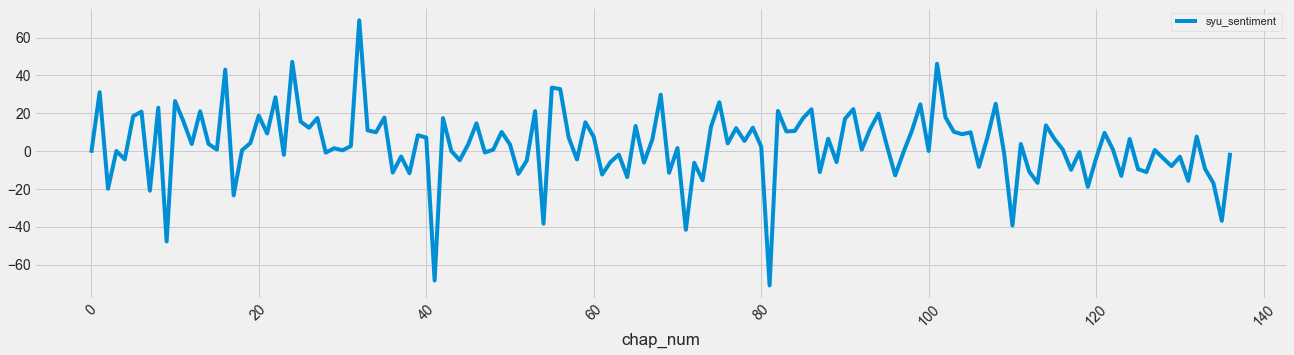

In [14]:
tokens.groupby(CHAPS)[emo].sum().plot(**FIG)

### By Paragraph

In [15]:
by_para = tokens.groupby(PARAS)[emo_cols].sum()

In [16]:
max_x = by_para.shape[0]
xticks = list(range(0, max_x, 100))
xticks.append(max_x - 1)

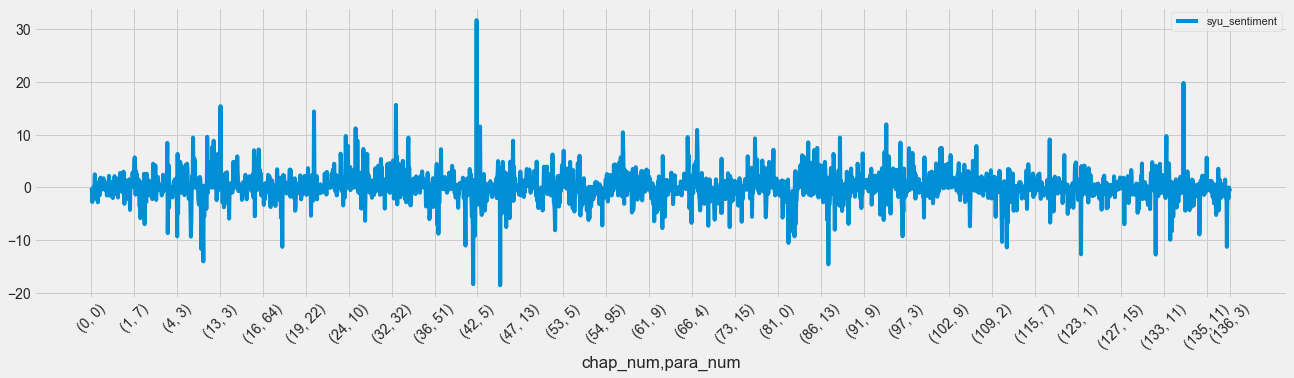

In [17]:
by_para[emo].plot(**FIG, xticks=xticks)

### By Sentence

In [18]:
by_sent = tokens.groupby(SENTS)[emo_cols].sum()

In [19]:
max_x = by_sent.shape[0]
xticks = list(range(0, max_x, 250))
xticks.append(max_x - 1)

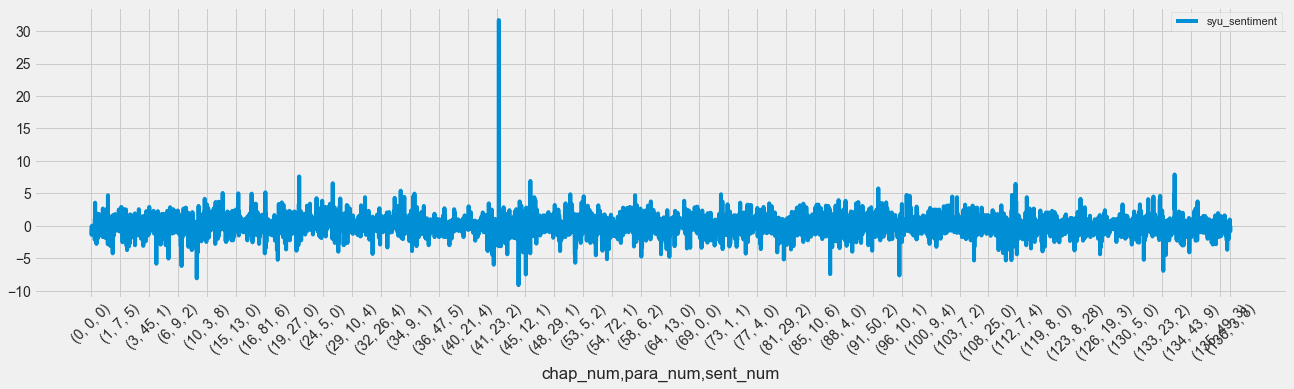

In [20]:
by_sent[emo].plot(**FIG, xticks=xticks)

### Add text to do spot checks

In [21]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [22]:
tokens['html'].head()

chap_num  para_num  sent_num  token_num
0         0         0         0            <span class='sent0'>ETYMOLOGY</span>
          1         0         1             <span class='sent0'>Supplied</span>
                              2                   <span class='sent0'>by</span>
                              3                    <span class='sent0'>a</span>
                              4                <span class='sent-1'>Late</span>
Name: html, dtype: object

In [23]:
by_sent['sent_str'] = tokens.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_sent['html_str'] = tokens.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))

In [24]:
by_sent[['sent_str', 'html_str']].head()

sent_str  \
chap_num para_num sent_num                                                      
0        0        0                                                 etymology   
         1        0         supplied by a late consumptive usher to a gram...   
         2        0         the pale usher threadbare in coat heart body a...   
                  1         he was ever dusting his old lexicons and gramm...   
                  2         he loved to dust his old grammars it somehow m...   

                                                                     html_str  
chap_num para_num sent_num                                                     
0        0        0                      <span class='sent0'>ETYMOLOGY</span>  
         1        0         <span class='sent0'>Supplied</span> <span clas...  
         2        0         <span class='sent0'>The</span> <span class='se...  
                  1         <span class='sent0'>He</span> <span class='sen...  
                  2         <span class='sent0'>He</span> <span class='sen...

### Histogram

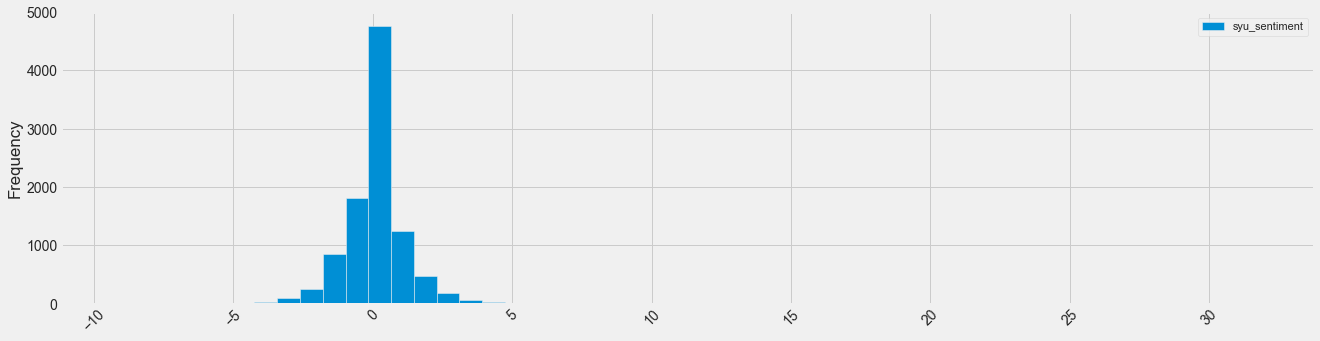

In [25]:
by_sent[emo].plot.hist(**FIG, bins=50)

### Look at a sample of sentences

In [26]:
rows = []
for idx in by_sent.sample(10).index:
    
    valence = round(by_sent.loc[idx, emo], 4)     
    t = 0
    if valence > t: color = '#ccffcc'
    elif valence < t: color = '#ffcccc'
    else: color = '#f2f2f2'
    z=0
    rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
    <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
    </tr>""".format(color, valence, by_sent.loc[idx, 'html_str'], idx))
    
display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

Sentiment,ID,Sentence
-1.6,"(91, 4, 2)",It may well be conceived what an unsavory odor such a mass must exhale worse than an Assyrian city in the plague when the living are incompetent to bury the departed
0.65,"(100, 28, 2)",I measured it with the lead line
0.5,"(56, 5, 1)",His jets are erect full and black like soot so that from so abounding a smoke in the chimney you would think there must be a brave supper cooking in the great bowels below
0.1,"(47, 2, 2)",There lay the fixed threads of the warp subject to but one single ever returning unchanging vibration and that vibration merely enough to admit of the crosswise interblending of other threads with its own
0.0,"(13, 15, 0)",Was there ever such unconsciousness
0.0,"(122, 0, 2)",Thunder and Lightning
0.0,"(73, 3, 0)",Nor was this long wanting
0.0,"(3, 4, 4)",Some were storied weapons
-0.25,"(85, 3, 11)",Now if after he fetches a few breaths you alarm him so that he sounds he will be always dodging up again to make good his regular allowance of air
1.5,"(78, 14, 4)",But the tendency to rapid sinking in this substance was in the present instance materially counteracted by the other parts of the head remaining undetached from it so that it sank very slowly and deliberately indeed affording Queequeg a fair chance for performing his agile obstetrics on the run as you may say


### Plot with Xticks

In [27]:
xticks = [0]
xticks += by_sent[emo].reset_index().sort_values(emo).head(7).index.values.tolist()
xticks += by_sent[emo].reset_index().sort_values(emo).tail(7).index.values.tolist()
xticks += [by_sent.shape[0] - 1]

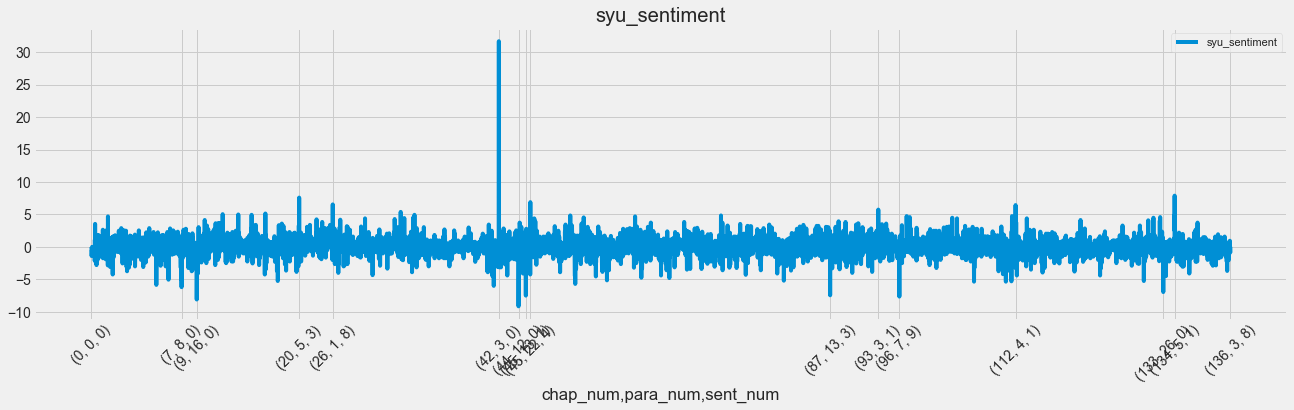

In [28]:
by_sent[emo].plot(**FIG, xticks=xticks, title=emo)

In [29]:
by_sent.iloc[xticks][emo].sort_index().to_frame()

syu_sentiment
chap_num para_num sent_num               
0        0        0                  0.00
7        8        0                 -6.20
9        16       0                 -8.10
20       5        3                  7.60
26       1        8                  6.55
42       3        0                 31.70
44       12       0                 -9.15
45       13       1                 -7.50
         22       4                  6.90
87       13       3                 -7.45
93       3        1                  5.75
96       7        9                 -7.65
112      4        1                  6.45
133      26       0                 -6.95
134      5        1                  7.90
136      3        8                 -0.90

### Inspect Positives

In [30]:
by_sent.sort_values(emo, ascending=False)[[emo,'sent_str']].head(20)

,,,syu_sentiment,sent_str
chap_num,para_num,sent_num,,
42,3,0,31.70,though in many natural objects whiteness refin...
134,5,1,7.90,for such is the wonderful skill prescience of ...
20,5,3,7.60,and like a sister of charity did this charitab...
45,22,4,6.90,but i must be content with only one more and a...
26,1,8,6.55,his pure tight skin was an excellent fit and c...
112,4,1,6.45,he had been an artisan of famed excellence and...
93,3,1,5.75,but while hapless dough boy was by nature dull...
33,2,5,5.40,nevertheless as upon the good conduct of the h...
16,81,9,5.15,i know captain ahab well i ve sailed with him ...


### Inspect Negatives

In [31]:
by_sent.sort_values(emo, ascending=True)[[emo,'sent_str']].head(20)

,,,syu_sentiment,sent_str
chap_num,para_num,sent_num,,
44,12,0,-9.15,often when forced from his hammock by exhausti...
9,16,0,-8.10,like one who after a night of drunken revelry ...
96,7,9,-7.65,as they narrated to each other their unholy ad...
45,13,1,-7.50,the dark ocean and swelling waters were nothin...
87,13,3,-7.45,and when he glanced upon the green walls of th...
133,26,0,-6.95,and now while both elastic gunwales were sprin...
7,8,0,-6.20,in what census of living creatures the dead of...
41,20,2,-6.00,yet when by this collision forced to turn towa...
3,56,2,-5.85,ignorance is the parent of fear and being comp...


## Apply Transforms

### Adapt Jockers' original FFT function 

Fast Fourier Transform. See https://rdrr.io/cran/syuzhet/man/get_transformed_values.html

In [32]:
def get_transformed_values(raw_values, low_pass_size = 2, x_reverse_len = 100,  padding_factor = 2, scale_values = False, scale_range = False):

    if low_pass_size > len(raw_values):
        sys.exit("low_pass_size must be less than or equal to the length of raw_values input vector")

    raw_values_len = len(raw_values)
    padding_len = raw_values_len * padding_factor

    # Add padding, then fft
    values_fft = fftpack.fft(raw_values, padding_len)
    low_pass_size = low_pass_size * (1 + padding_factor)
    keepers = values_fft[:low_pass_size]

    # Preserve frequency domain structure
    modified_spectrum = list(keepers) \
        + list(np.zeros((x_reverse_len * (1+padding_factor)) - (2*low_pass_size) + 1)) \
        + list(reversed(np.conj(keepers[1:(len(keepers))])))
    
    # Strip padding
    inverse_values = fftpack.ifft(modified_spectrum)
    inverse_values = inverse_values[:x_reverse_len]

    transformed_values = np.real(inverse_values)
    return transformed_values

In [33]:
FFTCFG = dict(
    low_pass_size = 3,
    x_reverse_len = 100,
    padding_factor = 2
)
X = get_transformed_values(by_sent[emo].values, **FFTCFG)

/Users/rca2t/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


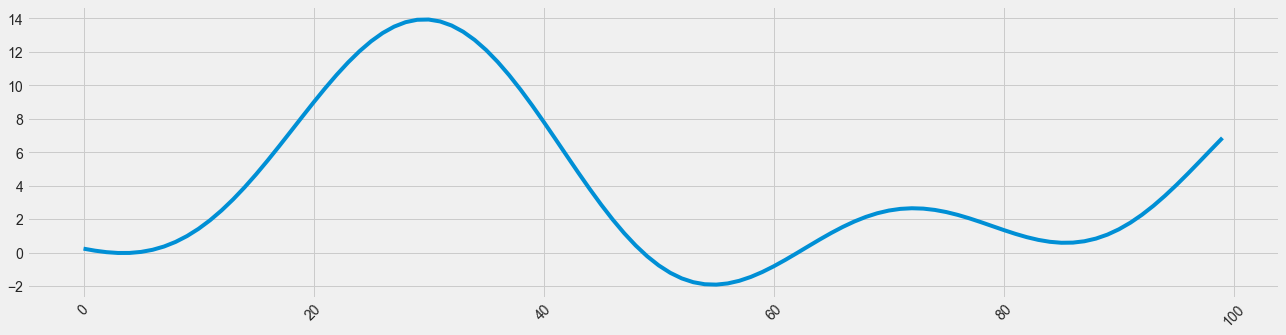

In [34]:
FIG['legend'] = False
pd.Series(X).plot(**FIG)

### Adapt Jockers' revised DCT function

Discrete Cosine Transform. A DCT is a Fourier-related transform similar to the discrete Fourier transform (DFT), but using only real numbers. 

In [35]:
def get_dct_transform(raw_values, low_pass_size = 5, x_reverse_len = 100):
    if low_pass_size > len(raw_values):
        raise ValueError("low_pass_size must be less than or equal to the length of raw_values input vector")
    values_dct = fftpack.dct(raw_values, type = 2)
    keepers = values_dct[:low_pass_size]
    padded_keepers = list(keepers) + list(np.zeros(x_reverse_len - low_pass_size))
    dct_out = fftpack.idct(padded_keepers)
    return(dct_out)

In [36]:
FFTCFG1 = dict(
    low_pass_size = 5,
    x_reverse_len = 100
)
X1 = get_dct_transform(by_sent[emo].values, **FFTCFG1)

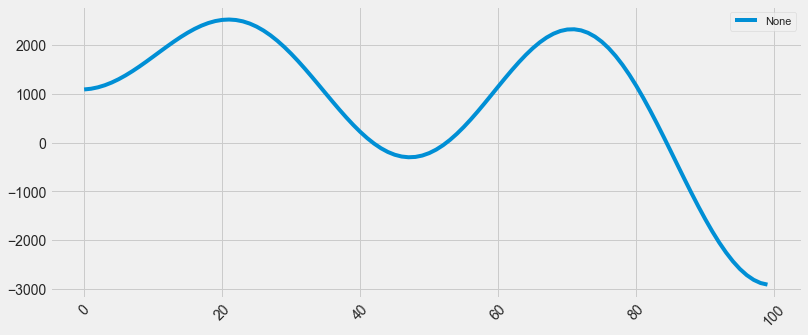

In [37]:
FIG['legend'] = True
FIG['figsize'] = (12,5)
pd.Series(X1).plot(**FIG)

<img src="moby_rplot.jpg" width="900" />

### Using Rolling
**Window types**: 
boxcar
triang
blackman
hamming
bartlett
parzen
bohman
blackmanharris
nuttall
barthann
kaiser (needs beta)
gaussian (needs std)
general_gaussian (needs power, width)
slepian (needs width).

In [38]:
# Config for sentences
CFG1 = dict(
    win_type='triang',
    window=3000,
    center=True
)

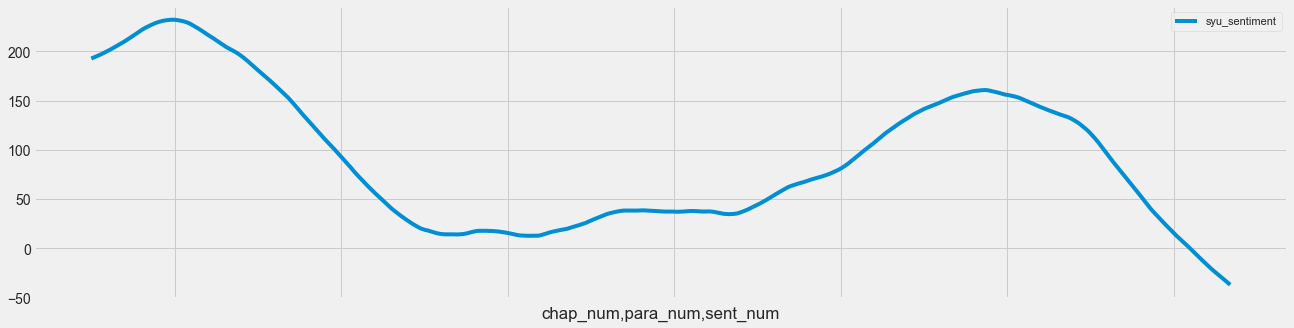

In [39]:
FIG['figsize'] = (20,5)
by_sent[emo].fillna(0).rolling(**CFG1).sum().plot(**FIG)

In [40]:
# Config for tokens
CFG2 = dict(
    win_type='triang',
    window= int(tokens.shape[0]/ 9),
    center=True
)
FIG['legend'] = True
CFG2['window']

24294

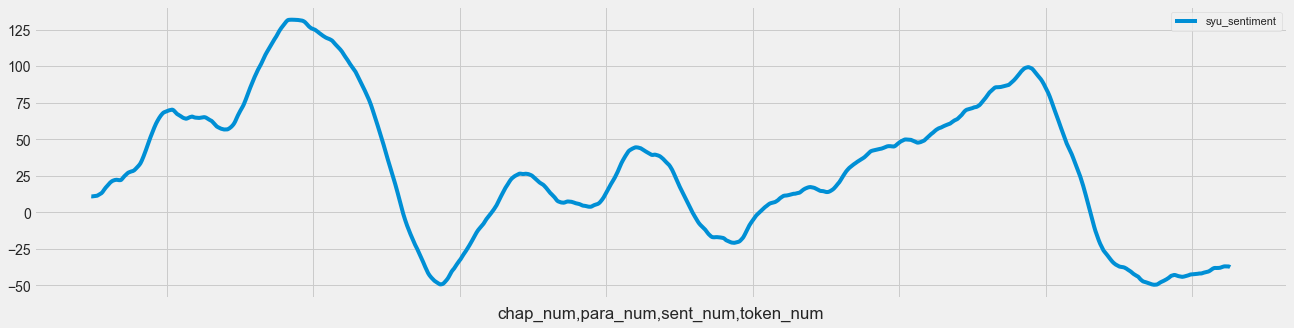

In [41]:
tokens[emo].fillna(0).rolling(**CFG2).sum().plot(**FIG)

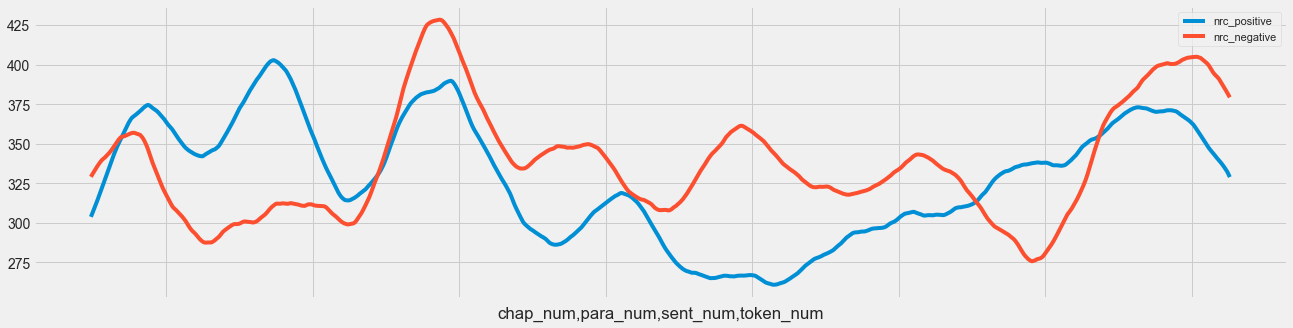

In [42]:
tokens[['nrc_positive','nrc_negative']].rolling(**CFG2).sum().plot(**FIG)

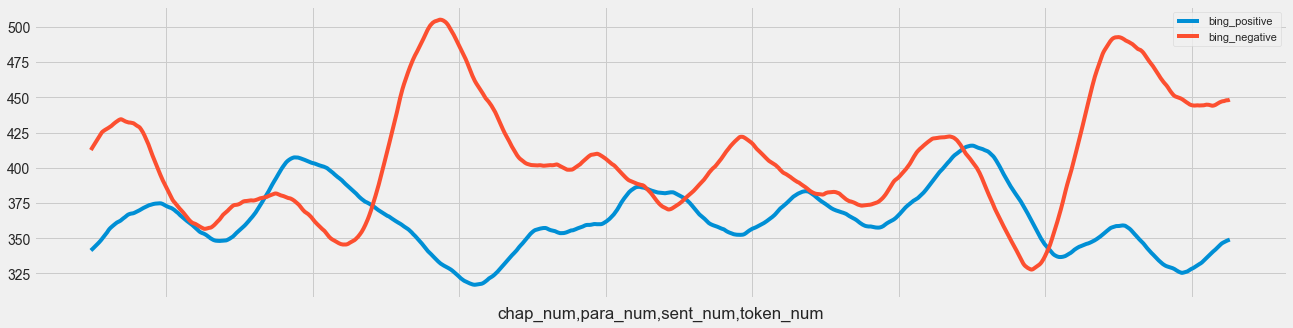

In [43]:
tokens[['bing_positive','bing_negative']].fillna(0).rolling(**CFG2).sum().plot(**FIG)

## Multinomial Emotions

In [44]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [45]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.25,0.0


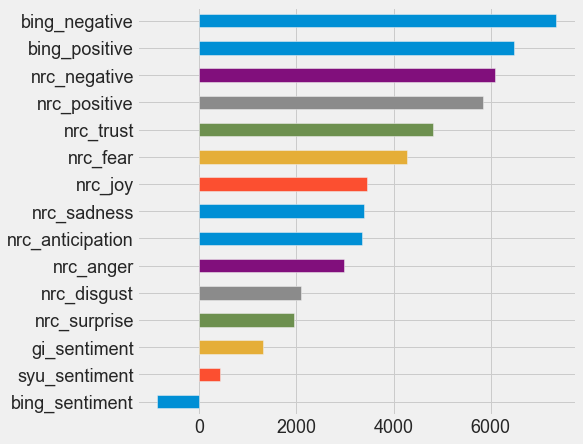

In [46]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18)

### Shape data for Sklearn's KDE function

In [47]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [48]:
B

,x
emo,
nrc_anger,"[[67], [214], [250], [331], [438], [488], [496..."
nrc_anticipation,"[[146], [210], [214], [297], [331], [381], [43..."
nrc_disgust,"[[159], [214], [331], [378], [400], [525], [55..."
nrc_fear,"[[67], [214], [257], [331], [344], [378], [438..."
nrc_joy,"[[78], [116], [267], [297], [381], [472], [501..."
nrc_negative,"[[4], [67], [146], [159], [210], [214], [250],..."
nrc_positive,"[[6], [13], [78], [109], [116], [141], [146], ..."
nrc_sadness,"[[4], [67], [159], [214], [257], [331], [344],..."
nrc_surprise,"[[78], [210], [445], [632], [948], [975], [102..."


### Get KDE for each emotion

In [49]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
# kde_bandwidth = 250
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

### Visualize KDE plots

In [50]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T

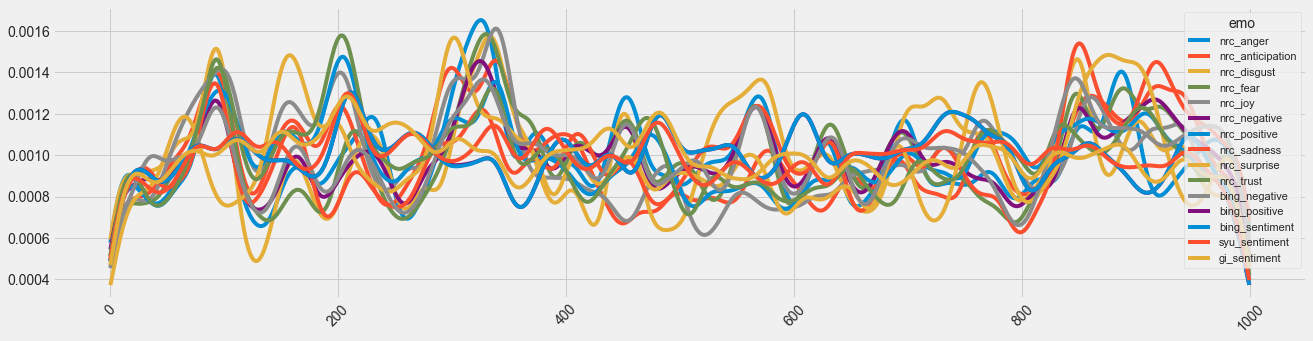

In [51]:
PLOTS.plot(**FIG)

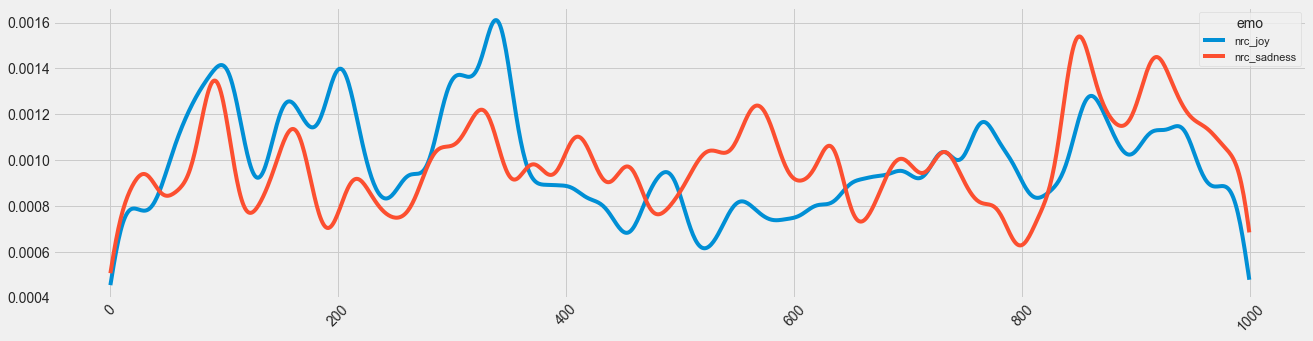

In [52]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

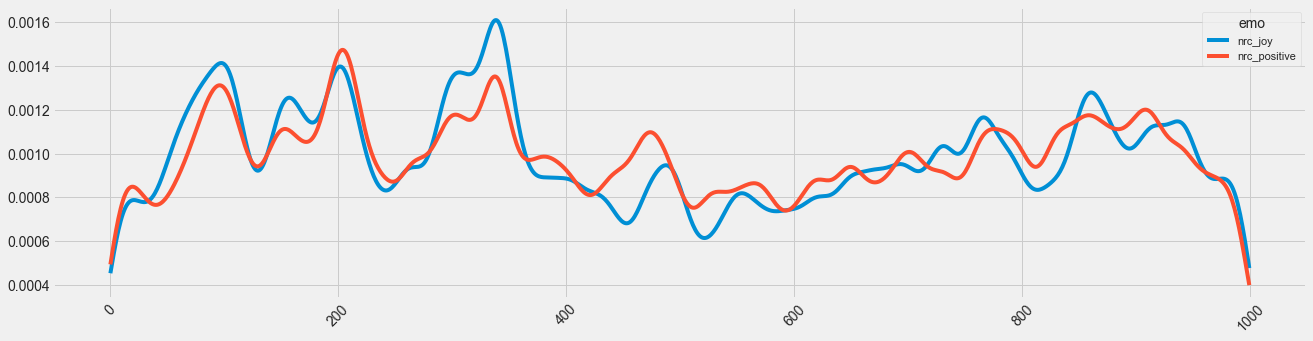

In [53]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)

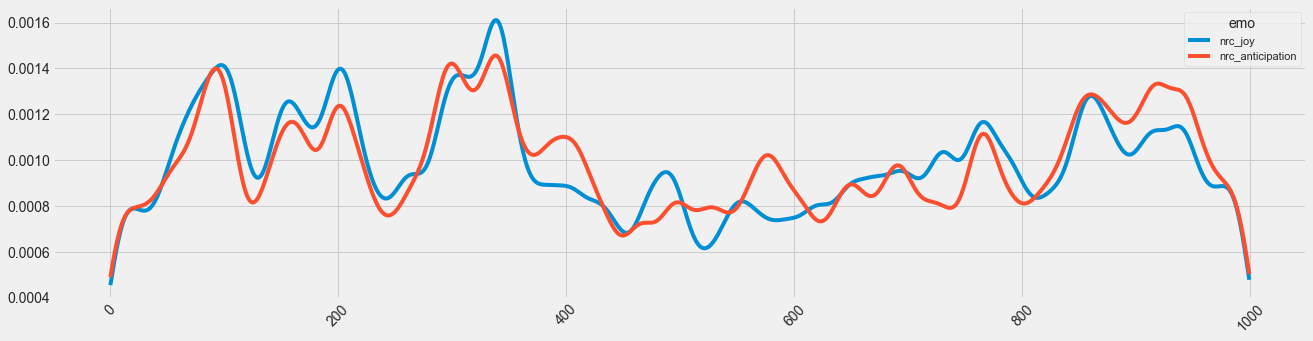

In [54]:
PLOTS[['nrc_joy','nrc_anticipation']].plot(**FIG)

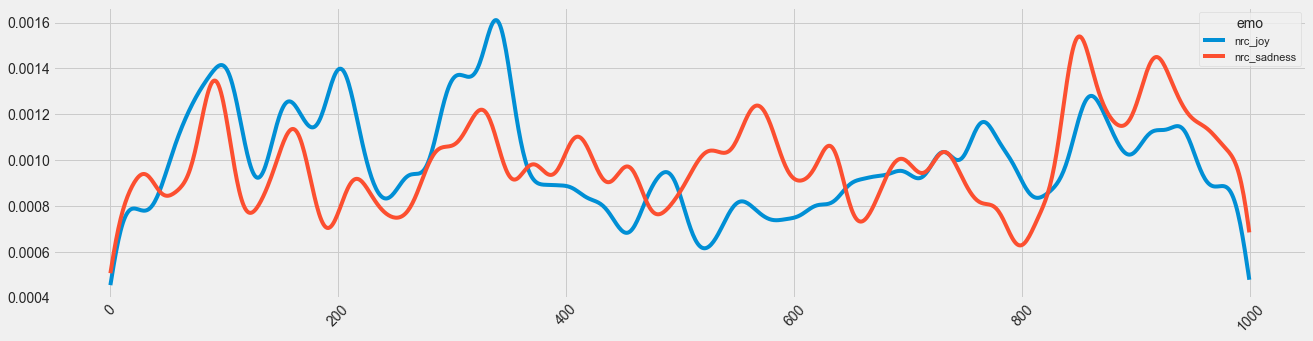

In [55]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

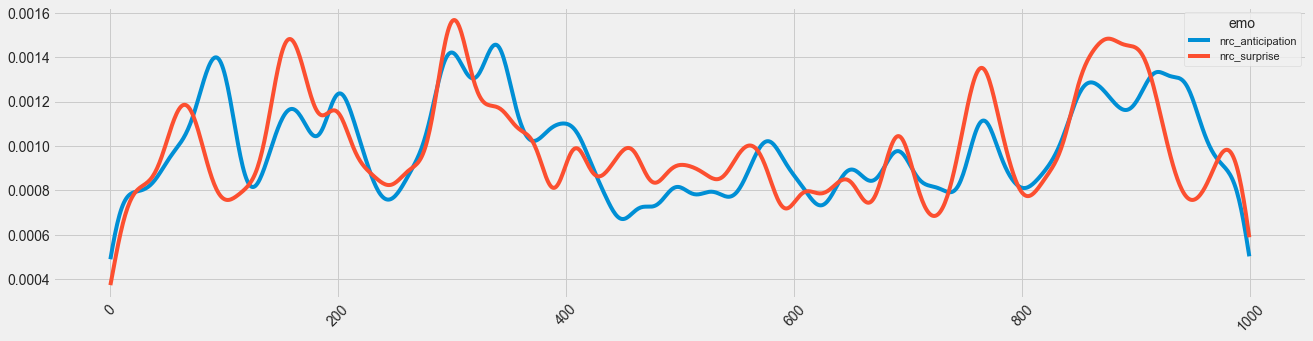

In [56]:
PLOTS[['nrc_anticipation','nrc_surprise']].plot(**FIG)

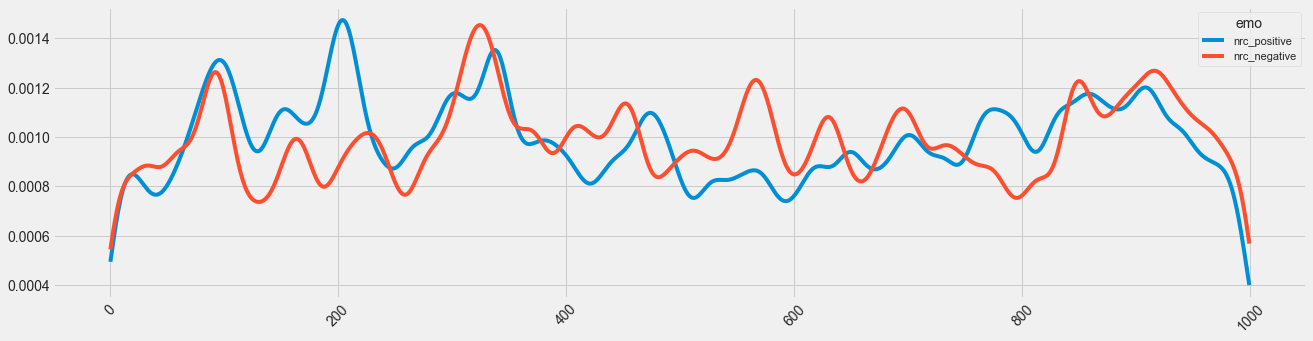

In [57]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)

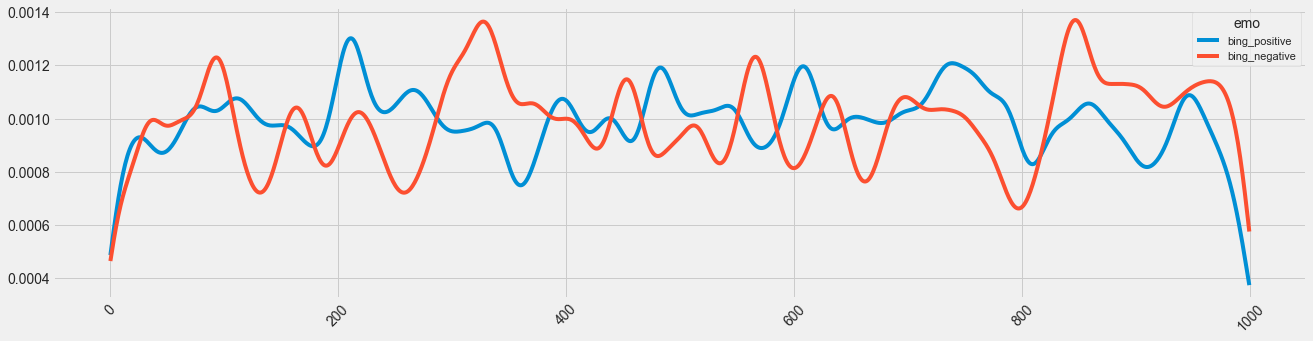

In [58]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)

### Compare KDE to Rolling graphs of Sentiment

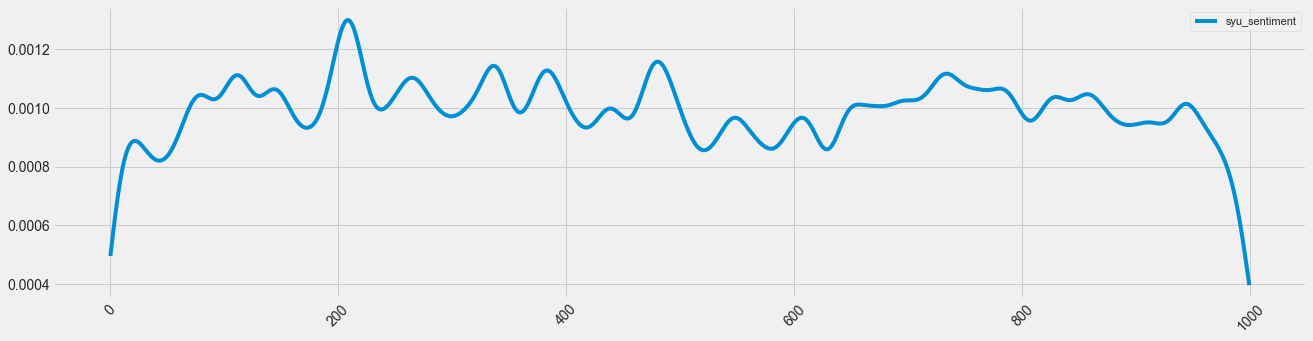

In [59]:
PLOTS[emo].plot(**FIG)

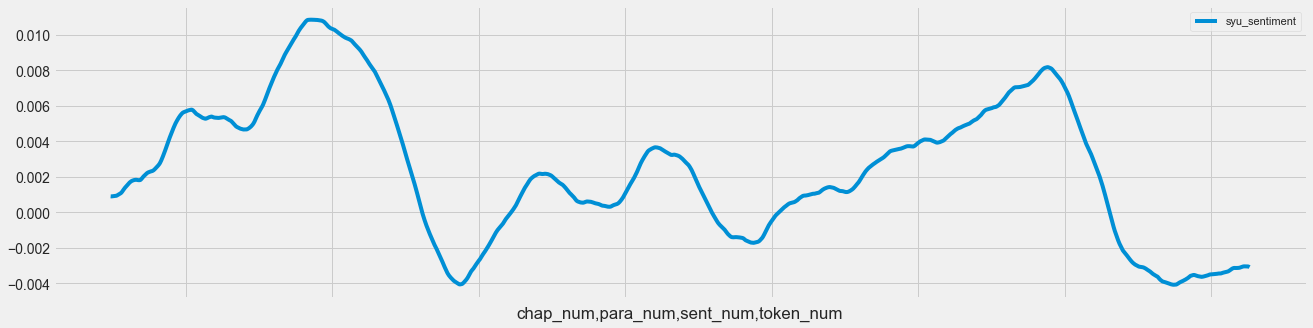

In [60]:
tokens[emo].fillna(0).rolling(**CFG2).mean().plot(**FIG)

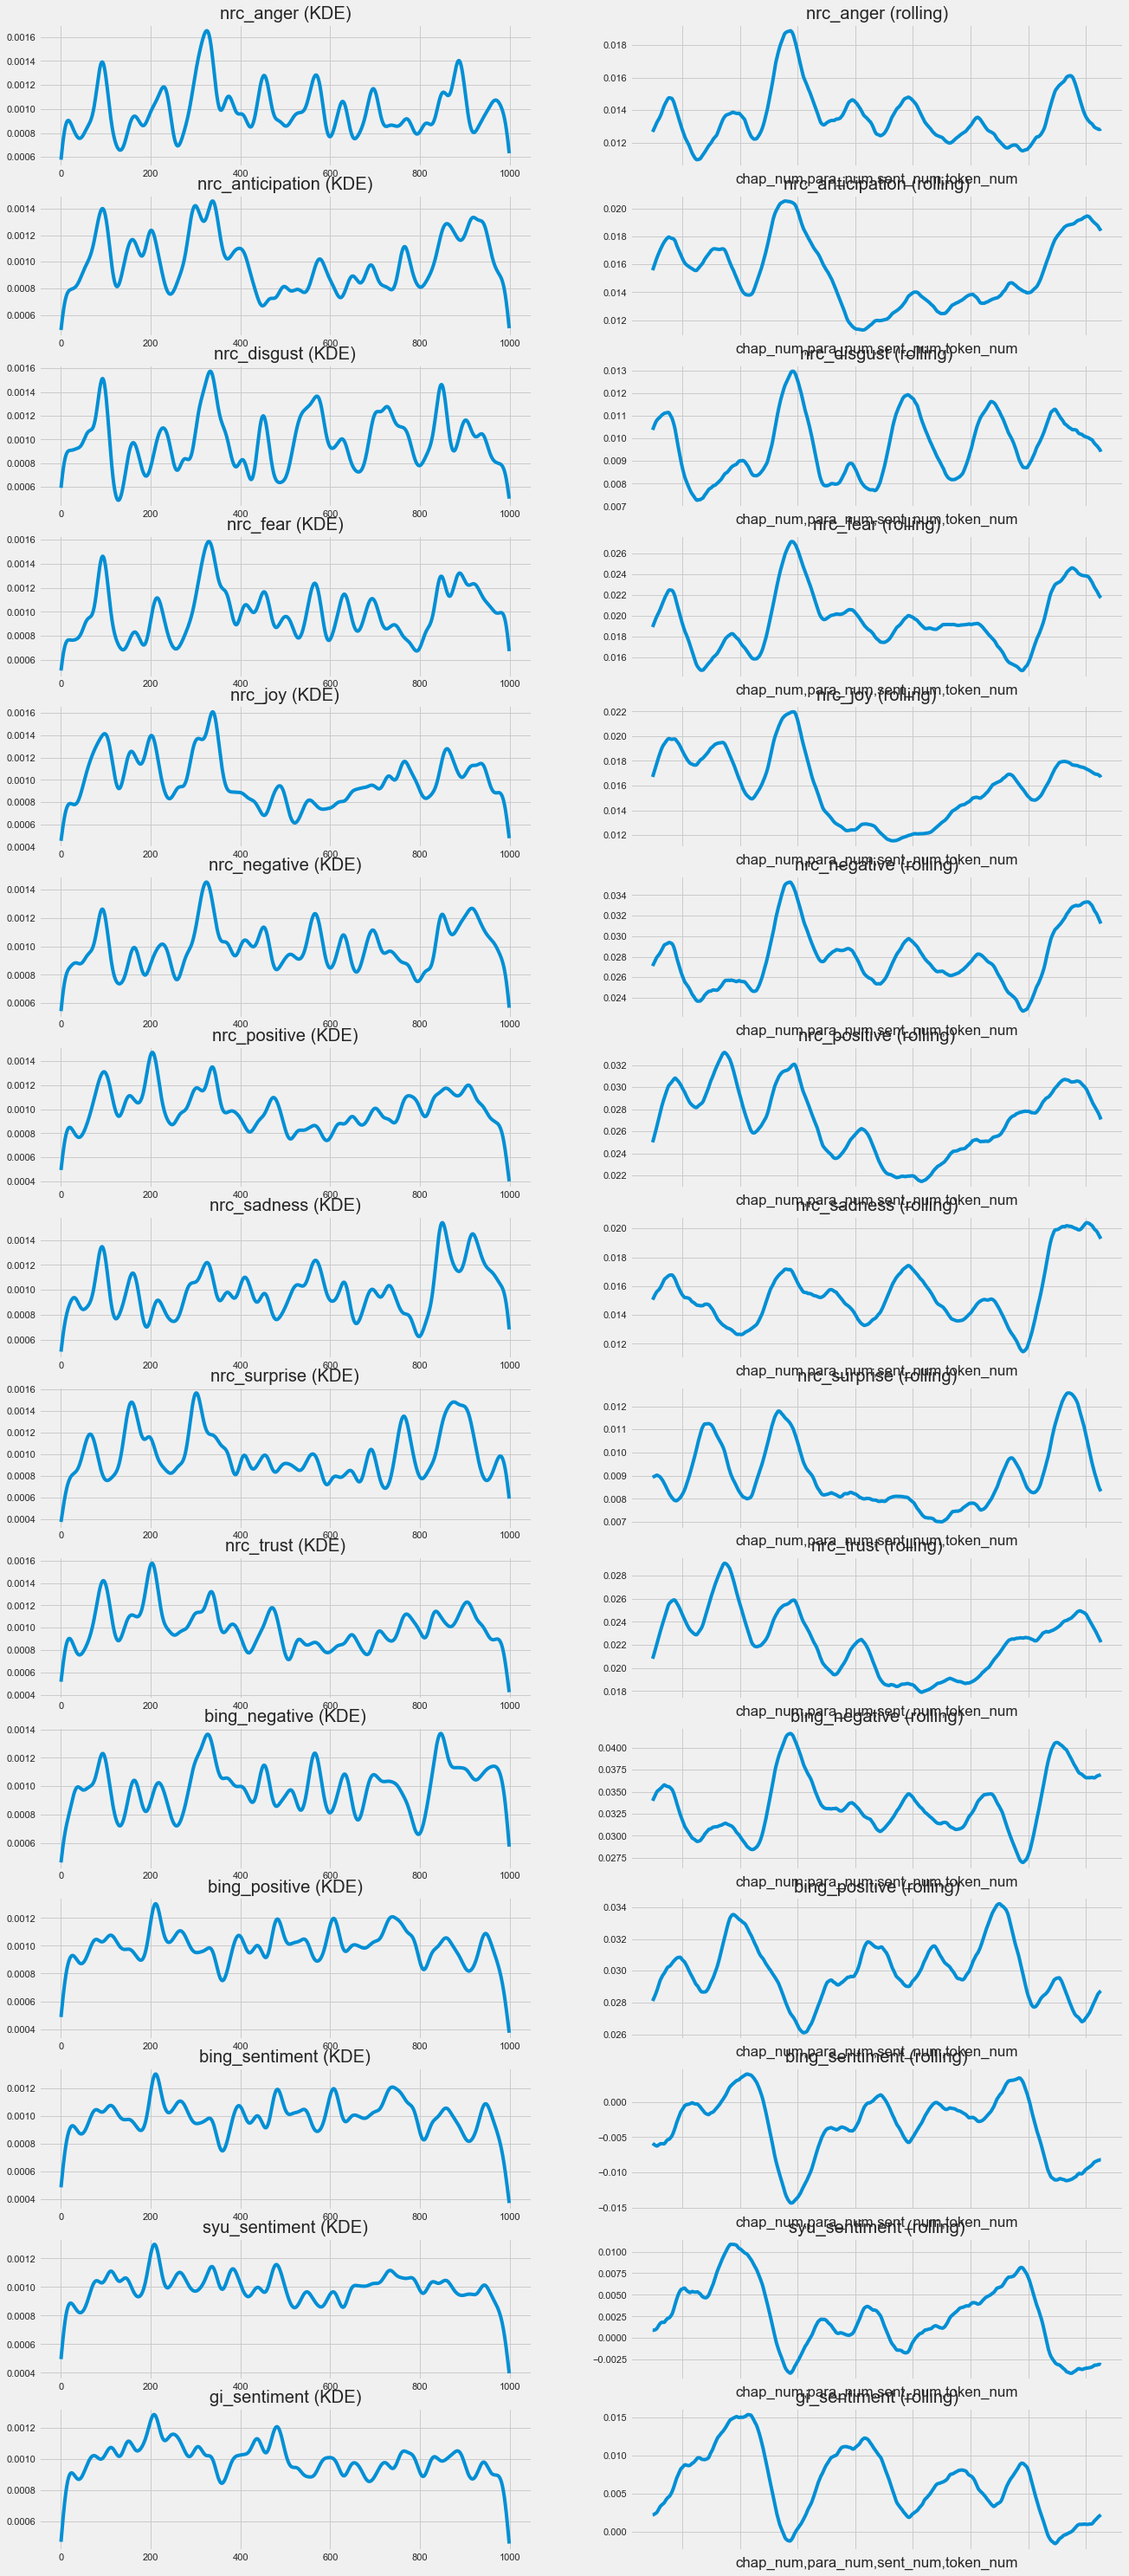

In [61]:
fig, axs = plt.subplots(len(emo_cols),2)
for i, emo in enumerate(emo_cols):
    FIGa = dict(figsize=(20,50), ax=axs[i,0], title=emo + ' (KDE)')
    FIGb = dict(figsize=(20,50), ax=axs[i,1], title=emo + ' (rolling)')
    PLOTS[emo].plot(**FIGa)
    tokens[emo].rolling(**CFG2).mean().plot(**FIGb)

## Peak Joy

### Find max joy from PLOTS

In [62]:
PLOTS.head()

emo,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.000578,0.000489,0.000593,0.000513,0.000454,0.000544,0.000494,0.000506,0.000372,0.000516,0.000465,0.000487,0.000487,0.000495,0.000470
1,0.000614,0.000519,0.000628,0.000543,0.000485,0.000576,0.000527,0.000537,0.000400,0.000551,0.000492,0.000519,0.000519,0.000529,0.000503
2,0.000650,0.000548,0.000662,0.000572,0.000515,0.000606,0.000559,0.000567,0.000428,0.000586,0.000519,0.000552,0.000552,0.000562,0.000536
3,0.000683,0.000575,0.000694,0.000600,0.000545,0.000634,0.000591,0.000596,0.000456,0.000620,0.000545,0.000583,0.000583,0.000594,0.000569
4,0.000716,0.000601,0.000724,0.000625,0.000573,0.000661,0.000621,0.000625,0.000483,0.000653,0.000570,0.000614,0.000614,0.000626,0.000601


In [63]:
PEAK_JOY = int((PLOTS['nrc_joy'].idxmax() / 1000) * tokens.shape[0])

In [64]:
PEAK_JOY_CHAP_NUM = tokens.iloc[PEAK_JOY].name[0]

In [65]:
PEAK_JOY_CHAP_NUM + 1

43

### Display Chapter

In [66]:
PEAK_JOY_CHAP = tokens.loc[PEAK_JOY_CHAP_NUM].groupby(['para_num']).token_str.apply(lambda x: ' '.join(x)).tolist()

In [67]:
display(HTML('<br/><br/>'.join(PEAK_JOY_CHAP)))

### Sparknotes' Synopsis

> One night, the Elliots receive an invitation to the Dalrymples' place, and Anne tells her family she must decline it because she has an engagement to visit Mrs. Smith. Sir Walter is horrified that Anne should be visiting such a poor neighborhood and is appalled that she chooses to associate with someone so much lower in consequence than herself.

https://www.sparknotes.com/lit/persuasion/section9/

## VADER

In [68]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [69]:
vader_cols = by_sent.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))

In [70]:
by_sent = pd.concat([by_sent, vader_cols], axis=1)

In [71]:
by_sent.head()

nrc_anger  nrc_anticipation  nrc_disgust  \
chap_num para_num sent_num                                             
0        0        0               0.0               0.0          0.0   
         1        0               0.0               0.0          0.0   
         2        0               0.0               0.0          0.0   
                  1               0.0               0.0          0.0   
                  2               1.0               0.0          0.0   

                            nrc_fear  nrc_joy  nrc_negative  nrc_positive  \
chap_num para_num sent_num                                                  
0        0        0              0.0      0.0           0.0           0.0   
         1        0              0.0      0.0           1.0           1.0   
         2        0              0.0      0.0           0.0           1.0   
                  1              0.0      0.0           0.0           0.0   
                  2              1.0      0.0           1.0           0.0   

                            nrc_sadness  nrc_surprise  nrc_trust    ...     \
chap_num para_num sent_num                                          ...      
0        0        0                 0.0           0.0        0.0    ...      
         1        0                 1.0           0.0        1.0    ...      
         2        0                 0.0           0.0        1.0    ...      
                  1                 0.0           0.0        0.0    ...      
                  2                 1.0           0.0        0.0    ...      

                            bing_positive  bing_sentiment  syu_sentiment  \
chap_num para_num sent_num                                                 
0        0        0                   0.0             0.0           0.00   
         1        0                   0.0             0.0          -0.25   
         2        0                   0.0            -1.0          -1.40   
                  1                   0.0            -2.0          -0.85   
                  2                   1.0             0.0          -0.50   

                            gi_sentiment  \
chap_num para_num sent_num                 
0        0        0                  0.0   
         1        0                 -1.0   
         2        0                  1.0   
                  1                  0.0   
                  2                  0.0   

                                                                     sent_str  \
chap_num para_num sent_num                                                      
0        0        0                                                 etymology   
         1        0         supplied by a late consumptive usher to a gram...   
         2        0         the pale usher threadbare in coat heart body a...   
                  1         he was ever dusting his old lexicons and gramm...   
                  2         he loved to dust his old grammars it somehow m...   

                                                                     html_str  \
chap_num para_num sent_num                                                      
0        0        0                      <span class='sent0'>ETYMOLOGY</span>   
         1        0         <span class='sent0'>Supplied</span> <span clas...   
         2        0         <span class='sent0'>The</span> <span class='se...   
                  1         <span class='sent0'>He</span> <span class='sen...   
                  2         <span class='sent0'>He</span> <span class='sen...   

                            neg    neu    pos  compound  
chap_num para_num sent_num                               
0        0        0         0.0  1.000  0.000    0.0000  
         1        0         0.0  1.000  0.000    0.0000  
         2        0         0.0  1.000  0.000    0.0000  
                  1         0.0  1.000  0.000    0.0000  
                  2         0.0  0.782  0.218    0.5994  

[5 rows x 21 columns]

In [79]:
by_sent.sort_values('neg', ascending=False).head(10)

,,,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,...,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment,sent_str,html_str,neg,neu,pos,compound
chap_num,para_num,sent_num,,,,,,,,,,,,,,,,,,,,,
72,10,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,no,<span class='sent0'>No</span>,1.0,0.0,0.0,-0.2960
110,15,19,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,-1.0,-0.75,-1.0,shame,<span class='sent-1'>shame</span>,1.0,0.0,0.0,-0.4767
40,37,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,-0.80,0.0,no offence,<span class='sent0'>No</span> <span class='sen...,1.0,0.0,0.0,-0.5267
18,26,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,no,<span class='sent0'>No</span>,1.0,0.0,0.0,-0.2960
105,6,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,no,<span class='sent0'>No</span>,1.0,0.0,0.0,-0.2960
134,43,5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,-1.0,-0.75,-1.0,fool,<span class='sent-1'>Fool</span>,1.0,0.0,0.0,-0.4404
34,4,2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,-1.0,-0.75,-1.0,a problem,<span class='sent0'>A</span> <span class='sent...,1.0,0.0,0.0,-0.4019
40,48,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,no,<span class='sent0'>No</span>,1.0,0.0,0.0,-0.2960
132,12,45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.00,0.0,no no,<span class='sent0'>No</span> <span class='sen...,1.0,0.0,0.0,-0.5267


In [73]:
CFG1['window'] = 500

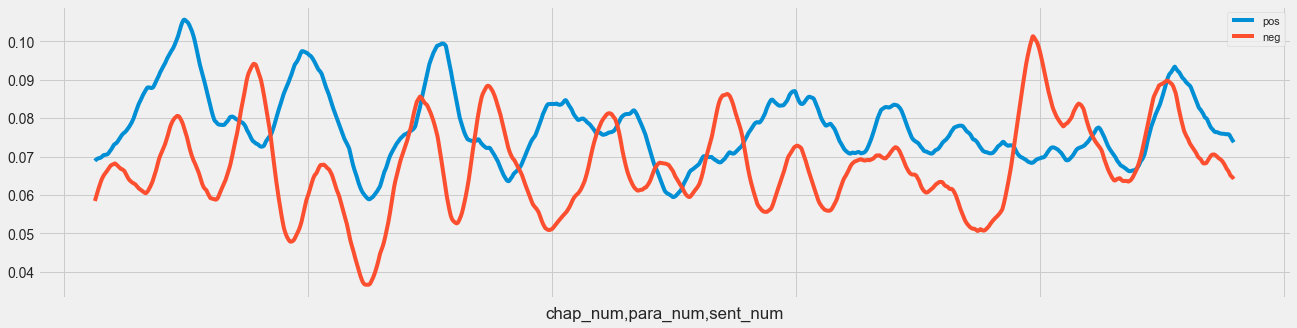

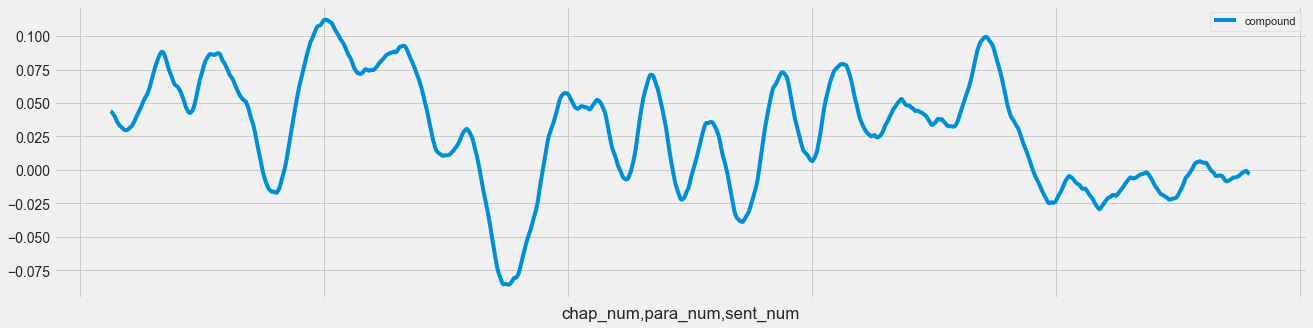

In [74]:
by_sent[['pos','neg']].rolling(**CFG1).mean().plot(**FIG)
by_sent[['compound']].rolling(**CFG1).mean().plot(**FIG)

## Compare KDE to Rolling Both Graphs of Syuzhet and VADER

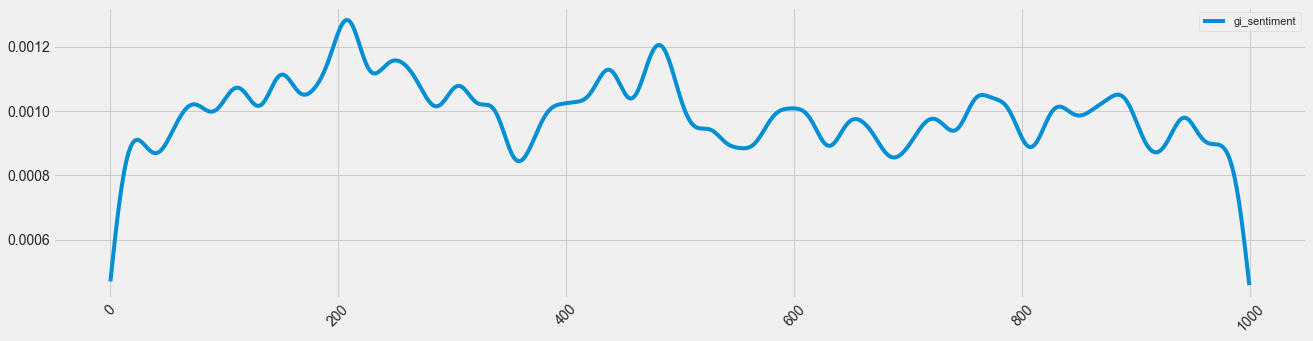

In [75]:
PLOTS[emo].plot(**FIG)

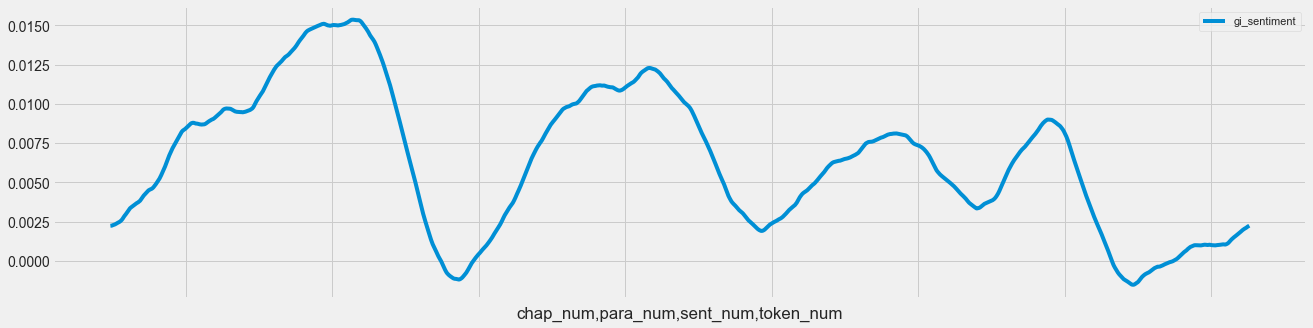

In [76]:
tokens[emo].fillna(0).rolling(**CFG2).mean().plot(**FIG)

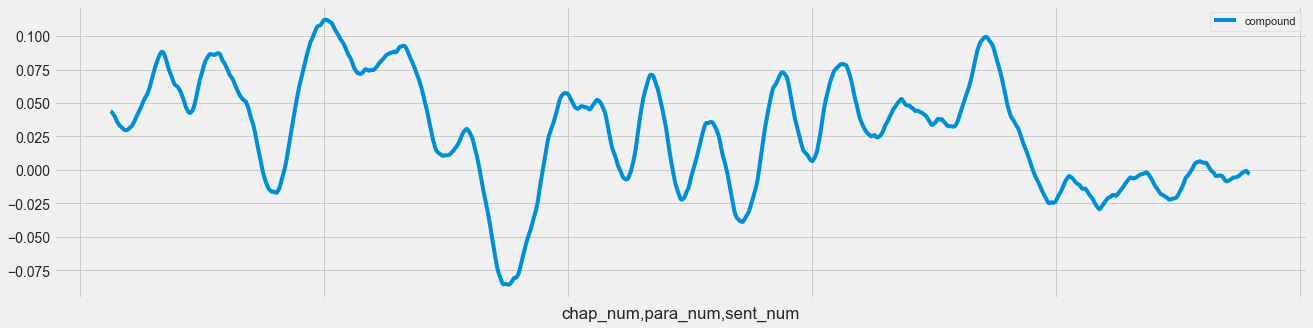

In [77]:
by_sent[['compound']].rolling(**CFG1).mean().plot(**FIG)

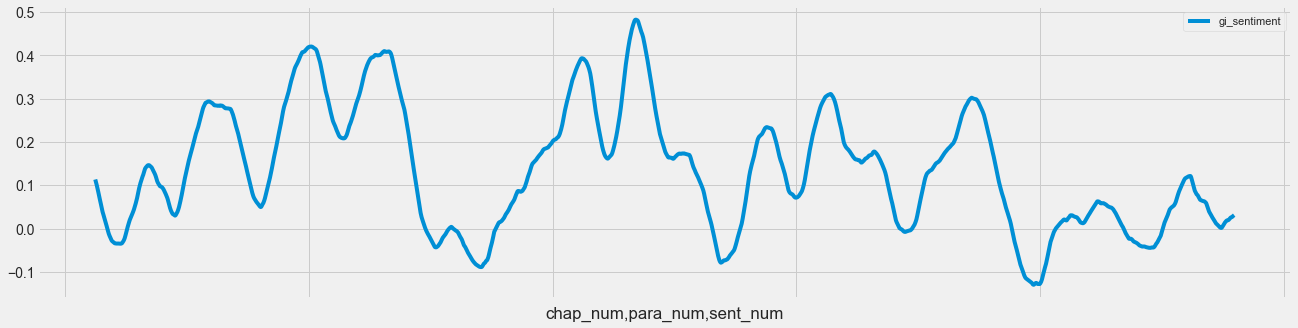

In [78]:
by_sent[emo].fillna(0).rolling(**CFG1).mean().plot(**FIG)